# T/S Plot from WOA data

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import gsw

In [3]:
url = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/archive/data/0114815/public/temperature/netcdf/A5B2/1.00/woa13_A5B2_t00_01.nc'
surl = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/archive/data/0114815/public/salinity/netcdf/A5B2/1.00/woa13_A5B2_s00_01.nc'
ds_salt = xr.open_dataset(url, decode_times=False)
ds_temp = xr.open_dataset(surl, decode_times=False)
ds = xr.merge([ds_salt, ds_temp])
ds

<xarray.Dataset>
Dimensions:             (lat: 180, nbounds: 2, lon: 360, depth: 102, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * depth               (depth) float32 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time                (time) float32 6.0
Dimensions without coordinates: nbounds
Data variables: (12/19)
    crs                 int32 -2147483647
    lat_bnds            (lat, nbounds) float32 -90.0 -89.0 -89.0 ... 89.0 90.0
    lon_bnds            (lon, nbounds) float32 -180.0 -179.0 ... 179.0 180.0
    depth_bnds          (depth, nbounds) float32 0.0 2.5 ... 5.45e+03 5.5e+03
    climatology_bounds  (time, nbounds) float32 0.0 12.0
    t_an                (time, depth, lat, lon) float32 ...
    ...                  ...
    s_mn                (time, depth, lat, lon) float32 ...
    s_dd                (time, depth, lat, lon) float64 ...
    s_sd                (time, depth, lat, lon) float32 ...
    s_se                (time, depth, lat, lon) float32 ...
    s_oa                (time, depth, lat, lon) float32 ...
    s_gp                (time, depth, lat, lon) float64 ...
Attributes: (12/44)
    Conventions:                   CF-1.6
    title:                         World Ocean Atlas 2013 version 2 : sea_wat...
    summary:                       Climatological mean temperature for the gl...
    references:                    Locarnini, R. A., A. V. Mishonov, J. I. An...
    institution:                   National Oceanographic Data Center(NODC)
    comment:                       global climatology as part of the World Oc...
    ...                            ...
    nodc_template_version:         NODC_NetCDF_Grid_Template_v1.0
    license:                       These data are openly available to the pub...
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    metadata_link:                 http://www.nodc.noaa.gov/OC5/WOA13/pr_woa1...
    date_created:                  2011-09-28 
    date_modified:                 2011-09-28

### WG region

In [4]:
#WG boundaries (65˚W, 30˚E; 80˚S, 57˚S)
lower_lat = -79.5
upper_lat = -57.5
left_lon = -64.5
right_lon = 30.5

In [5]:
#set the boundaries
lat_range = dict(lat=slice(lower_lat, upper_lat))
lon_range = dict(lon=slice(left_lon, right_lon))

In [7]:
temp = ds.t_an.sel(**lat_range, **lon_range)
salt = ds.s_an.sel(**lat_range, **lon_range)

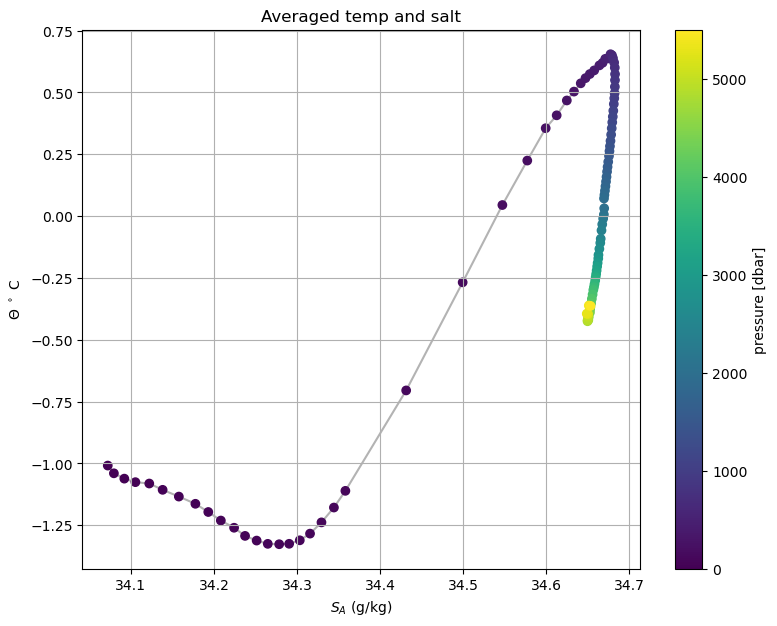

In [10]:
fig, ax = plt.subplots(figsize=(9,7))
plt.plot(salt[0].mean(dim=['lon', 'lat']), temp[0].mean(dim=['lon', 'lat']), c='0.7', zorder=-999)
scat = ax.scatter(salt[0].mean(dim=['lon', 'lat']), temp[0].mean(dim=['lon', 'lat']), c=ds.depth)
ax.set_xlabel(r'$S_A$ (g/kg)')
ax.set_ylabel(r'$\Theta$ $^\circ$ C')
plt.colorbar(scat, label='pressure [dbar]')
plt.grid()
plt.title('Averaged temp and salt');

In [11]:
xdimension_salt = np.arange(33.13249969,34.86949921,0.1)
ydimension_temp = np.arange(-2.08280993,3.91970992,0.2)

print(np.shape(ydimension_temp), np.shape(xdimension_salt))

(31,) (18,)


In [12]:
sigma = np.empty([18,31])
for j in range(18):
    for i in range(31):
        sigma[j, i] = gsw.sigma2(xdimension_salt[j],ydimension_temp[i])

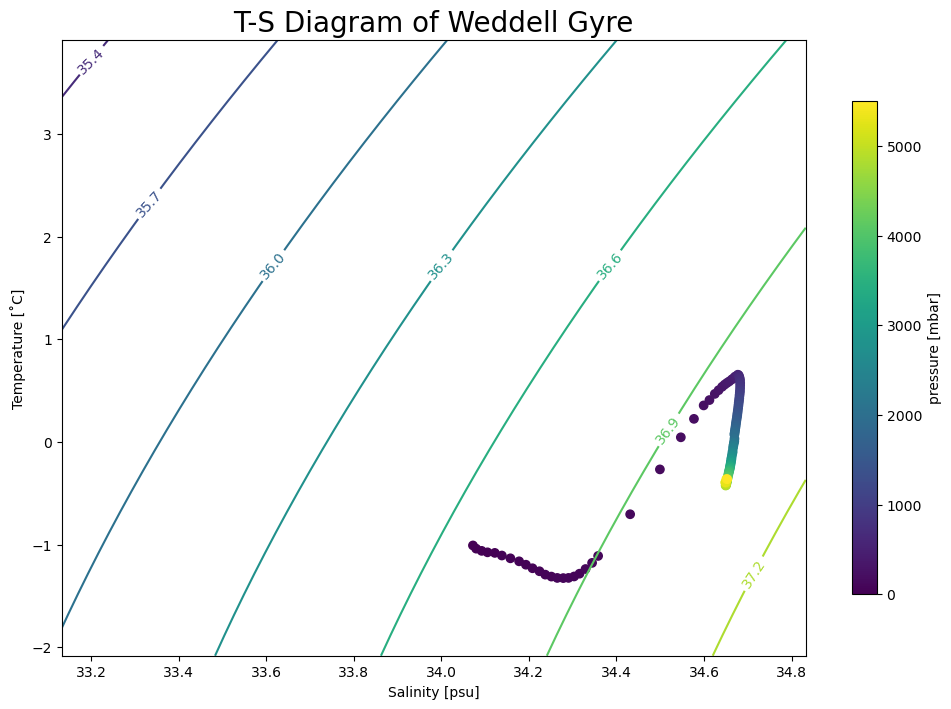

In [14]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

C = plt.contour(xdimension_salt, ydimension_temp, sigma.T)
plt.clabel(C)
scat = ax.scatter(salt[0].mean(dim=['lat', 'lon']), temp[0].mean(dim=['lat', 'lon']), c=ds.depth)
plt.colorbar(scat, label='pressure [mbar]', shrink=0.8)

ax.set_xlabel('Salinity [psu]')
ax.set_ylabel('Temperature [˚C]')
ax.set_title('T-S Diagram of Weddell Gyre', fontsize=20);

In [15]:
ds_wg = ds.sel(**lat_range, **lon_range)

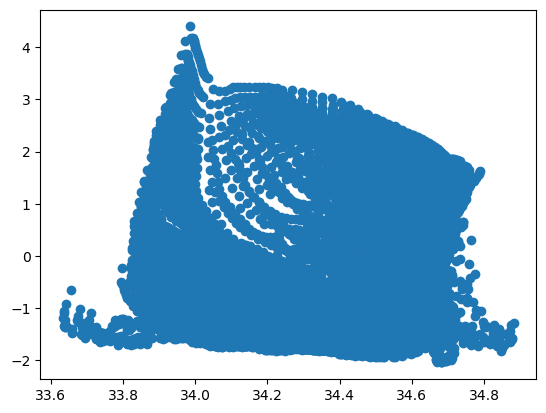

In [25]:
#setting up every data-point to be plotted on TS-diagram
salinity_vector = 1
temp_vector = 1
for i in range(len(ds_wg.lat)):
    for j in range(len(ds_wg.lon)):
        salinity_vector = np.append(salinity_vector, salt[0, :, i, j])
        temp_vector = np.append(temp_vector, temp[0, :, i, j])

Salt = salinity_vector[1:]
Temp = temp_vector[1:]

plt.scatter(Salt, Temp)

In [26]:
lev_vector = 1
for i in range(int((len(Salt)/102))):
    lev_vector = np.append(lev_vector, ds_wg.depth)
    
lev = lev_vector[1:]

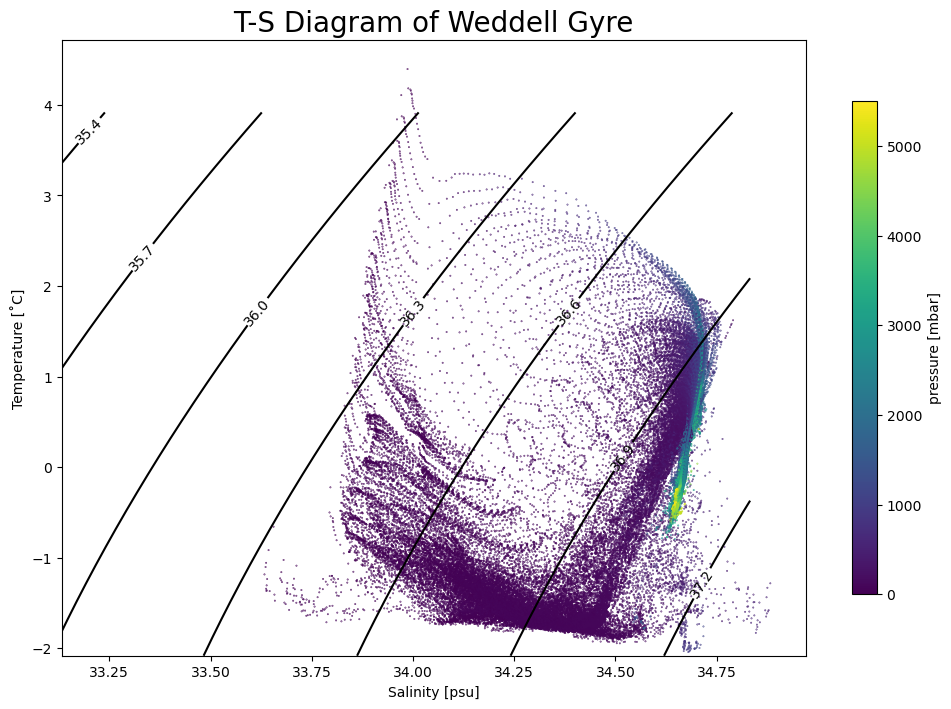

In [27]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

C = plt.contour(xdimension_salt, ydimension_temp, sigma.T, colors='k')
plt.clabel(C)

#scat = ax.scatter(Salt, Temp, c=ds.lev)
scat = ax.scatter(Salt, Temp, c = lev, marker='.', s=0.5)
plt.colorbar(scat, label='pressure [mbar]', shrink=0.8)

ax.set_xlabel('Salinity [psu]')
ax.set_ylabel('Temperature [˚C]')
ax.set_title('T-S Diagram of Weddell Gyre', fontsize=20);

In [28]:
type(Salt)

numpy.ndarray

In [29]:
TS_scatter = xr.Dataset({'Salt' : Salt, 'Temp' : Temp})

In [30]:
#saving to avoid running loop
TS_scatter.to_netcdf('/home/jovyan/chapter1/WOA/TS_scatter.nc', mode='w')

## Volume-weighted TS
xhistogram

In [58]:
# Create a dz variable
dz = np.diff(ds_wg.depth)
dz = np.insert(dz, 0, dz[0]) #inserts 1st value of original dz into the first index to make it same size as ds.lev
dz = xr.DataArray(dz, coords= {'depth':ds_wg.depth}, dims='depth')

dlat = np.diff(ds_wg.lat)[0]

# check that spacing is uniform
np.testing.assert_allclose(np.diff(ds_wg.lat), dlat)
dlon = np.diff(ds_wg.lon)[0]
np.testing.assert_allclose(np.diff(ds_wg.lon), dlon)
(dlon, dlat)

(1.0, 1.0)

In [59]:
rad_earth = 6378.1e3 #meters

#create a dy variable
dy = rad_earth * np.deg2rad(dlat)
dy

#create a dx variable
dx = rad_earth * np.deg2rad(dlon) * np.cos(np.deg2rad(ds_wg.lat))

In [60]:
area, _, _ = xr.broadcast(dx * dy, ds_wg.lat, ds_wg.lon)
area

<xarray.DataArray 'lat' (lat: 23, lon: 96)>
array([[2.2582415e+09, 2.2582415e+09, 2.2582415e+09, ..., 2.2582415e+09,
        2.2582415e+09, 2.2582415e+09],
       [2.4705446e+09, 2.4705446e+09, 2.4705446e+09, ..., 2.4705446e+09,
        2.4705446e+09, 2.4705446e+09],
       [2.6820951e+09, 2.6820951e+09, 2.6820951e+09, ..., 2.6820951e+09,
        2.6820951e+09, 2.6820951e+09],
       ...,
       [6.2893573e+09, 6.2893573e+09, 6.2893573e+09, ..., 6.2893573e+09,
        6.2893573e+09, 6.2893573e+09],
       [6.4747428e+09, 6.4747428e+09, 6.4747428e+09, ..., 6.4747428e+09,
        6.4747428e+09, 6.4747428e+09],
       [6.6581545e+09, 6.6581545e+09, 6.6581545e+09, ..., 6.6581545e+09,
        6.6581545e+09, 6.6581545e+09]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -79.5 -78.5 -77.5 -76.5 ... -60.5 -59.5 -58.5 -57.5
  * lon      (lon) float32 -64.5 -63.5 -62.5 -61.5 -60.5 ... 27.5 28.5 29.5 30.5

In [61]:
land_mask = ds_wg.t_an.isnull()

In [62]:
dV = area * dz
dV_wg = dV.where(~land_mask[0])

In [63]:
dV_wg.sum()

<xarray.DataArray ()>
array(2.9890943e+16, dtype=float32)
Coordinates:
    time     float32 6.0

In [64]:
#salt_bins = np.linspace(33, 35, 100)
#theta_bins = np.linspace(-2.2, 4.2, 100)

salt_bins = np.linspace(31, 35, 100) #to match model bins
theta_bins = np.linspace(-2.5, 8, 100) #to match model bins

delta_salt = salt_bins[1] - salt_bins[0]
delta_theta = theta_bins[1] - theta_bins[0]

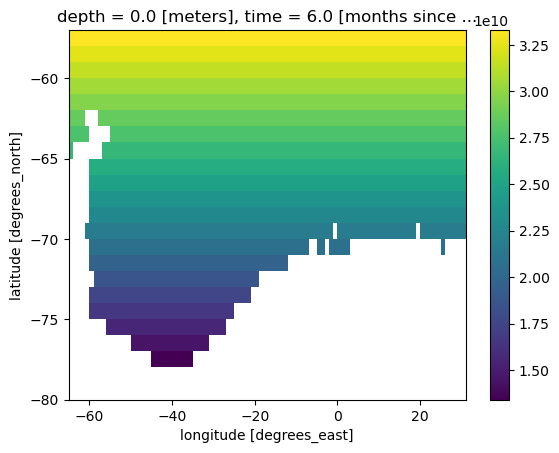

In [65]:
dV_wg[:,:,0].plot()

In [72]:
from xhistogram.xarray import histogram
from matplotlib.colors import LogNorm

In [68]:
ts_hist_0512 = histogram(temp[0].rename('theta'), salt[0].rename('salt'), 
                    bins=[theta_bins, salt_bins], 
                    weights=dV_wg,
                    dim=['lon', 'lat', 'depth']) / (delta_salt * delta_theta)

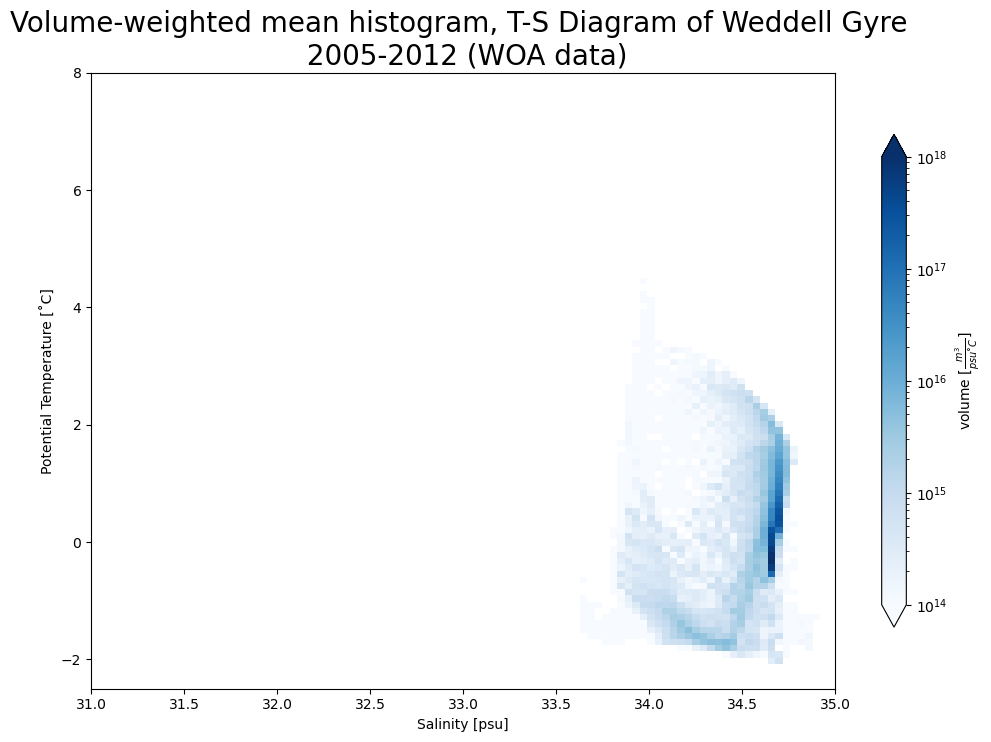

In [73]:
ts_hist_0512.where(ts_hist_0512>0).plot(norm=LogNorm(), figsize=(12,8), cmap='Blues',
                              cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'},
                              vmin=1e14, vmax=1e18)

plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')
plt.title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 2005-2012 (WOA data)', fontsize=20);

In [ ]:
ts_hist_0512.to_netcdf('ts_hist_0512.nc')